<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-1">Preprocessing</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-2">Model</a></span><ul class="toc-item"><li><span><a href="#MLP" data-toc-modified-id="MLP-2.1">MLP</a></span></li><li><span><a href="#GRU" data-toc-modified-id="GRU-2.2">GRU</a></span></li></ul></li></ul></div>

# Preprocessing

In [1]:
import torchtext
import spacy

#Embeddings
word_dim = 100
glove = torchtext.vocab.GloVe(name='6B', dim=word_dim)

#tokenizer model
nlp_en = spacy.load('en300')

In [2]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

wv_from_bin = KeyedVectors.load_word2vec_format("data/model.bin", binary=True) 

In [216]:
import string
import jieba
import gensim 
import spacy
import numpy as np
import torch

stop_words = [line.rstrip() for line in open('data/chinese_stop_words.txt',"r", encoding="utf-8") ]

def get_sentence_vector_zh(line, mode):
    vectors = []
    for w in line:
        try:
            emb = wv_from_bin[w]
            vectors.append(emb)
        except:
            pass #Do not add if the word is out of vocabulary
    if vectors:
        vectors = np.array(vectors)
        # Outputs vector of shape (1)
        if mode==0:
            vectors = np.mean(vectors) 
        # Outputs vector of shape (word_dim)
        elif mode==1:
            vectors = np.mean(vectors, axis=0)
        # Outputs vector of shape (len(line), word_dim)
        elif mode==2:
            vectors = vectors
        return vectors
    else:
        if mode==0 or mode==1:
            return np.zeros(word_dim)
        elif mode==2:
            return np.zeros((1, word_dim), dtype=np.float32)


def processing_zh(sentence):
    seg_list = jieba.lcut(sentence,cut_all=True)
    doc = [word for word in seg_list if word not in stop_words]
    docs = [e for e in doc if e.isalnum()]
    return docs


def get_sentence_embeddings_zh(f, mode=0):
    file = open(f, encoding="utf8") 
    lines = file.readlines() 
    sentences_vectors = []
    for l in lines:
        sent  = processing_zh(l)
        vec = get_sentence_vector_zh(sent, mode=mode)
        if vec is not None:
            sentences_vectors.append(vec)
        else:
            print(l)
    return sentences_vectors

In [210]:
from nltk.corpus import stopwords
from tqdm import tqdm 

stop_words_en = set(stopwords.words('english'))

def preprocess(sentence,nlp):
    text = sentence.lower()
    doc = [token.lemma_ for token in  nlp.tokenizer(text)]
    doc = [word for word in doc if word not in stop_words_en]
    doc = [word for word in doc if word.isalpha()] #restricts string to alphabetic characters only
    return doc

def get_word_vector(embeddings, word):
    try:
        vec = embeddings.vectors[embeddings.stoi[word]]
        return vec
    except KeyError:
        #print(f"Word {word} does not exist")
        pass

def get_sentence_vector(embeddings,line,mode):
    vectors = []
    for w in line:
        emb = get_word_vector(embeddings,w)
        #do not add if the word is out of vocabulary
        if emb is not None:
            vectors.append(emb)
    # Outputs vector of shape (1)
    if mode==0:
        vectors = torch.mean(torch.stack(vectors))
    # Outputs vector of shape (word_dim)
    elif mode==1:
        vectors = torch.mean(torch.stack(vectors), axis=0)
    # Outputs vector of shape (len(line), word_dim)
    elif mode==2:
        vectors = torch.stack(vectors)
    return vectors.data.numpy()


def get_embeddings(f,embeddings,lang, mode=0):
    file = open(f, encoding="utf8") 
    lines = file.readlines() 
    sentences_vectors = []
    for l in lines:
        sentence = preprocess(l,lang)
        try:
            vec = get_sentence_vector(embeddings,sentence,mode)
            sentences_vectors.append(vec)
        except:
            if mode == 0 or mode == 1:
                sentences_vectors.append(np.zeros(word_dim))
            if mode == 2:
                print("Check if the dimension is correct")
                sentences_vectors.append(np.zeros((1, word_dim), dtype=np.float32))
    return sentences_vectors

In [5]:
import spacy
import torchtext
from torchtext import data

zh_train_mt = get_sentence_embeddings_zh("data/en-zh/train.enzh.mt", mode=1)
zh_train_src = get_embeddings("data/en-zh/train.enzh.src", glove, nlp_en, mode=1)
f_train_scores = open("data/en-zh/train.enzh.scores",'r')
zh_train_scores = f_train_scores.readlines()

zh_val_src = get_embeddings("data/en-zh/dev.enzh.src", glove, nlp_en, mode=1)
zh_val_mt = get_sentence_embeddings_zh("data/en-zh/dev.enzh.mt", mode=1)
f_val_scores = open("data/en-zh/dev.enzh.scores",'r')
zh_val_scores = f_val_scores.readlines()

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\gmler\AppData\Local\Temp\jieba.cache
Loading model cost 0.720 seconds.
Prefix dict has been built successfully.


In [6]:
print(f"Training mt: {len(zh_train_mt)} Training src: {len(zh_train_src)}")
print(f"Validation mt: {len(zh_val_mt)} Validation src: {len(zh_val_src)}")

Training mt: 7000 Training src: 7000
Validation mt: 1000 Validation src: 1000


In [8]:
import numpy as np

X_train = np.concatenate((np.asarray(zh_train_src), np.asarray(zh_train_mt)),axis=1) #[np.array(zh_train_src),np.array(zh_train_mt)]
X_train_zh = np.array(X_train).transpose()

X_val = np.concatenate((zh_val_src, zh_val_mt),axis=1) # [np.array(zh_val_src),np.array(zh_val_mt)]
X_val_zh = np.array(X_val).transpose()

#Scores
train_scores = np.array(zh_train_scores).astype(float)
y_train_zh = train_scores

val_scores = np.array(zh_val_scores).astype(float)
y_val_zh = val_scores

In [9]:
print(X_train.shape)

(7000, 200)


# Model

## MLP

In [493]:
def rmse(predictions, targets):
    res = np.sqrt(((predictions - targets) ** 2).mean())
    return res

In [59]:
import torch
import torch.nn.functional as F
import torch.nn as nn

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, 256)  
        self.hidden2 = torch.nn.Linear(256, 64)
        self.hidden3 = torch.nn.Linear(64, 16)
        self.predict = torch.nn.Linear(16, n_output) 

    def forward(self, x):
        x = F.relu(self.hidden(x))  
        x = F.relu(self.hidden2(x))  
        x = F.relu(self.hidden3(x))  
        x = self.predict(x)
        return x

In [417]:
def plot_loss(losses):
    import matplotlib.pyplot as plt
    plt.plot(list(range(len(losses))), losses)
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Training")
    plt.yscale('log')
    plt.show()

In [26]:
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr

net = Net(n_feature=200, n_output=1)     # define the network
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()  
batch_size = 64
steps = 20000
losses = []

for t in range(steps):
    curr_bat = np.random.choice(len(X_train), batch_size, replace=False)
    x = torch.Tensor(X_train[curr_bat])
    y = torch.Tensor(y_train_zh[curr_bat]).view(batch_size,-1)
    optimizer.zero_grad()
    prediction = net(x)    
    loss = loss_func(prediction, y)
    losses += [loss.item()]
    optimizer.zero_grad()   
    loss.backward()        
    optimizer.step()    
    if t % (steps // 10) == 0:
        with torch.no_grad():
            predictions = net(torch.Tensor(X_val)).flatten().data.numpy()
            pearson = pearsonr(y_val_zh, predictions)
            print(f'Steps: {t} RMSE: {rmse(predictions,y_val_zh)} Pearson {pearson[0]}')
plot_loss(losses)

Steps: 0 RMSE: 0.9291300791139017 Pearson -0.053951107931420175
Steps: 2000 RMSE: 0.9048851860453592 Pearson 0.1486338173531659
Steps: 4000 RMSE: 0.8912097192606878 Pearson 0.20137036168628714
Steps: 6000 RMSE: 0.8857761545875287 Pearson 0.2331506609074092
Steps: 8000 RMSE: 0.8925346237646622 Pearson 0.24284690217592694
Steps: 10000 RMSE: 0.8871090091547369 Pearson 0.23298747744557943
Steps: 12000 RMSE: 0.906784897323265 Pearson 0.19675027582230295
Steps: 14000 RMSE: 0.9255454088271616 Pearson 0.18469291260204176
Steps: 16000 RMSE: 0.9680189245085403 Pearson 0.17707735223519563
Steps: 18000 RMSE: 0.9547417582343691 Pearson 0.14707985994047298


<Figure size 640x480 with 1 Axes>

## GRU

In [217]:
zh_train_mt_m2 = get_sentence_embeddings_zh("data/en-zh/train.enzh.mt", mode=2)
zh_train_src_m2 = get_embeddings("data/en-zh/train.enzh.src", glove, nlp_en, mode=2)

zh_val_src_m2 = get_embeddings("data/en-zh/dev.enzh.src", glove, nlp_en, mode=2)
zh_val_mt_m2 = get_sentence_embeddings_zh("data/en-zh/dev.enzh.mt", mode=2)

In [223]:
def pad_to_max_length(sentences):
    max_len = max(l.shape[0] for l in sentences)
    return torch.stack(tuple(
                        F.pad(input=torch.tensor(l), pad=(0, 0, 0, max_len - l.shape[0]), mode='constant', value=0) 
                        for l in sentences))
    
zh_train_mt_pad = pad_to_max_length(zh_train_mt_m2)
zh_train_src_pad = pad_to_max_length(zh_train_src_m2)
zh_val_src_pad = pad_to_max_length(zh_val_src_m2)
zh_val_mt_pad = pad_to_max_length(zh_val_mt_m2)

In [395]:
batch_size = 64
# train_data = TensorDataset(zh_train_src_m2, torch.from_numpy(train_y))
# train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [473]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, fc_dim, n_layers, drop_prob=0):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru_en = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob).cuda()
        self.gru_zh = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob).cuda()
        self.fc = nn.Linear(fc_dim, output_dim).cuda()
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        x_en, x_zh = x[0].to("cuda"), x[1].to("cuda")
        h_en, h_zh = h[0].cuda(), h[1].cuda()
        out_en, h_en = self.gru_en(x_en, h_en)
        out_zh, h_zh = self.gru_zh(x_zh, h_zh)
        out = torch.cat((out_en, out_zh), 1)
        out = torch.mean(out, 1)
        out = self.fc(out)
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to("cuda")
        return hidden

Steps: 0 RMSE: 0.9006640315055847 Pearson -0.0650066475502234
Steps: 250 RMSE: 0.8969222903251648 Pearson 0.13456026309632851
Steps: 500 RMSE: 0.8936777710914612 Pearson 0.17747630749734372
Steps: 750 RMSE: 0.8914663791656494 Pearson 0.18379534076263526
Steps: 1000 RMSE: 0.8898171782493591 Pearson 0.188652588107861
Steps: 1250 RMSE: 0.888627290725708 Pearson 0.19169764872310477
Steps: 1500 RMSE: 0.887125551700592 Pearson 0.1936821201664863
Steps: 1750 RMSE: 0.8842979073524475 Pearson 0.19878911710027897
Steps: 2000 RMSE: 0.8828738331794739 Pearson 0.20093767500287904
Steps: 2250 RMSE: 0.8810858130455017 Pearson 0.20487799107576637
Steps: 2500 RMSE: 0.8802400231361389 Pearson 0.21073678920888378
Steps: 2750 RMSE: 0.8778890371322632 Pearson 0.21552955679595906
Steps: 3000 RMSE: 0.876763105392456 Pearson 0.2196039356955435
Steps: 3250 RMSE: 0.8756016492843628 Pearson 0.22511718757779656
Steps: 3500 RMSE: 0.8757474422454834 Pearson 0.22941252986698263
Steps: 3750 RMSE: 0.8731020092964172 P

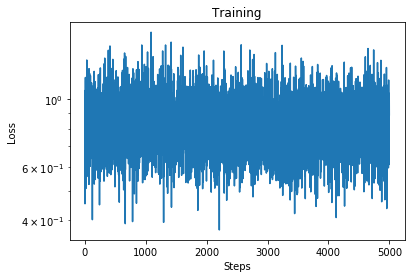

In [500]:
from scipy.stats.stats import pearsonr

input_dim = word_dim
hidden_dim=200
lr=0.01
batch_size = 64
steps = 5000
losses = []

X_en = zh_train_src_pad
X_zh = zh_train_mt_pad
h = gru.init_hidden(batch_size), gru.init_hidden(batch_size)

# fc_dim=(X_en.shape[1]+X_zh.shape[1])*hidden_dim
gru = GRUNet(input_dim, hidden_dim, fc_dim=(1)*hidden_dim, output_dim=1, n_layers=1)
# define the network
optimizer = torch.optim.SGD(gru.parameters(), lr)
loss_func = torch.nn.MSELoss()  


for t in range(steps):
    curr_bat = np.random.choice(len(X_en), batch_size, replace=False)
    x = X_en[curr_bat], X_zh[curr_bat]
    y = torch.Tensor(y_train_zh[curr_bat]).view(batch_size,-1).cuda()
    optimizer.zero_grad()
    prediction, h = gru(x, h)    
    loss = loss_func(prediction, y)
    losses += [loss.item()]
    optimizer.zero_grad()   
    loss.backward()        
    optimizer.step()    
    if t % (steps // 20) == 0:
        with torch.no_grad():
            predictions = torch.zeros(0, 64)
            for i in range(0, len(zh_val_src_pad)-batch_size, batch_size):
                pred, _ = gru((zh_val_src_pad[i: i+batch_size], zh_val_mt_pad[i:i+batch_size]), h)
                pred = pred.permute(1,0)
                predictions = torch.cat((predictions, pred.cpu()), 0)
            predictions = predictions.flatten()
            y_val_trunc = torch.Tensor(y_val_zh[:len(predictions)-len(predictions)%batch_size])
            pearson = pearsonr(y_val_trunc, predictions)
            print(f'Steps: {t} RMSE: {rmse(y_val_trunc, predictions)} Pearson {pearson[0]}')
plot_loss(losses)

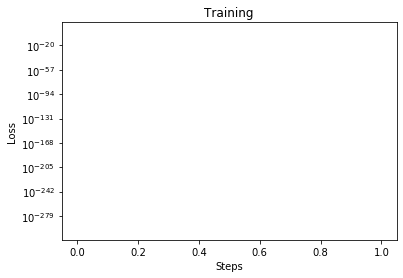

In [462]:
plot_loss(losses)